# Principle Component Analysis 

## Objectives

### **What** is PCA? 
- Set-up example problem with shipping costs data 
- Walk thru simple PCA problem start to finish 

### **Why** do we need PCA? 
- Discuss advantages/disadvantages of PCA 
- When would you want to use PCA? 

### **How** do we apply PCA to a data problem using sci-kit learn? 
- Apply each step in PCA manually to shipping data 
- Model shipping data with PCA components 
- Walk-thru a second example with cars data and pipelines 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Scenario: Shipping Costs
Let's say that we want to predict the cost to ship a package based on its properties.

White board walk-thru...

## Pros, cons and use cases of PCA 


> PCA is a feature extraction technique typically used to reduce dimensionality(Can you think of another one?). It combines our input variables in a way that allows us to drop the 'least important' variables while still retaining the most valuable parts. 

**More features** = More dimensions --> Overfitting 

### When to use it? 
1. When you want to eliminate features but are unsure which ones to remove.  
2. You want to create independent variables.  
3. Interpretability is not a priority. 

In [2]:
packages = pd.read_csv('data/packages.csv')
packages.head(10)

,Shipping Cost ($),Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
0,24,36,32,9,18,1079
1,38,41,31,12,18,1797
2,38,34,34,15,24,1722
3,20,32,22,8,8,461
4,24,37,24,14,19,491
5,21,32,20,3,6,1029
6,27,33,23,7,11,945
7,31,40,31,16,22,1649
8,30,37,28,12,20,1310
9,26,29,29,11,11,161


## Revisting Dimensionality
You can think about each variable as a dimension, and thus each package as a data point. If we take just one feature, we can easily visualize this in 2 dimensional space

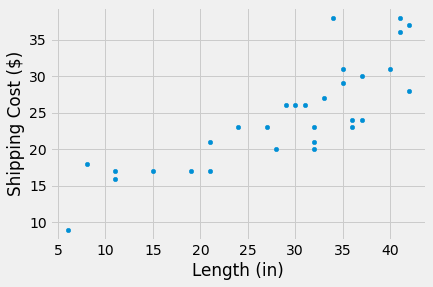

In [3]:
plt.style.use('fivethirtyeight')
packages.plot(kind='scatter', y='Shipping Cost ($)', x='Length (in)');

> You can think of each package as a point in six-dimensional space - 5 dimensions for our features and 1 for our target.

## Remember Correlation and Covariance Matrices?
The first four features in this dataset all relate to package size, so we might expect them to be strongly related.

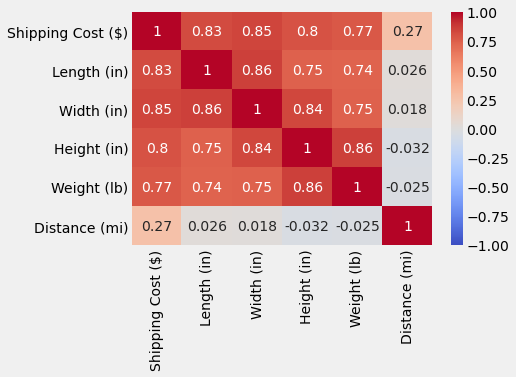

In [4]:
sns.heatmap(packages.corr(),
            annot=True,
            fmt='0.2g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap='coolwarm');

PCA does not use this correlation matrix, which is conveniently scaled between -1 and 1. Rather, it uses the covariance matrix, which is scaled in square units of the original variables. This makes PCA very sensitive to the scale of the variables.

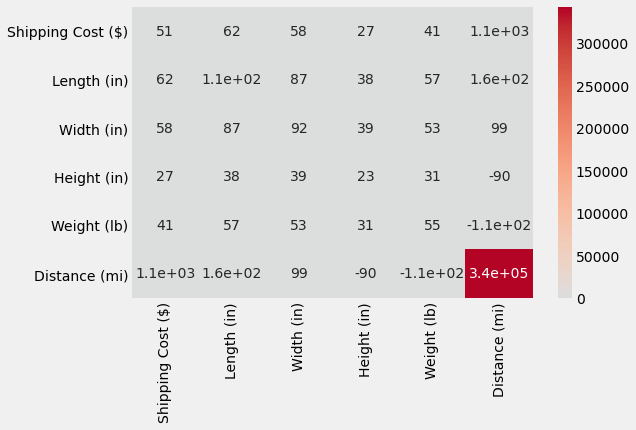

In [5]:
f, ax = plt.subplots(figsize=(8, 5))
ax = sns.heatmap(packages.cov(),
            annot=True,
            fmt='0.2g',
            center=0,
            cmap='coolwarm');

Let's normalize our variables to mean = 0 & SD = 1, which will make our covariance matrix equal the correlation matrix.

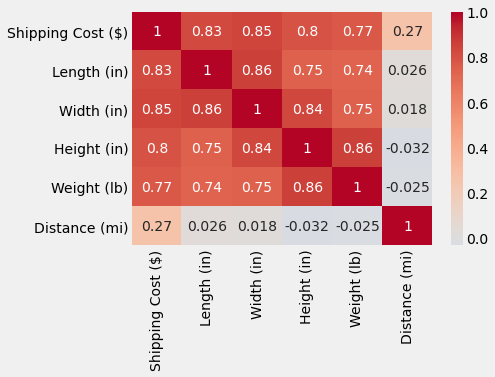

In [6]:
packages_scaled = (packages - packages.mean())/packages.std()
sns.heatmap(packages_scaled.cov(),
            annot=True,
            fmt='0.2g',
            center=0,
            cmap='coolwarm');

Notice that, for the centered data matrix $X$, the covariance matrix $C$ is equal to $\frac{1}{n-1}X^TX$:

In [7]:
packages_scaled.T.dot(packages_scaled) / (len(packages_scaled)-1)

,Shipping Cost ($),Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
Shipping Cost ($),1.000000,0.826989,0.849963,0.800307,0.774526,0.266277
Length (in),0.826989,1.000000,0.862847,0.746525,0.738311,0.026250
Width (in),0.849963,0.862847,1.000000,0.837949,0.747395,0.017698
Height (in),0.800307,0.746525,0.837949,1.000000,0.861819,-0.032043
Weight (lb),0.774526,0.738311,0.747395,0.861819,1.000000,-0.024568
Distance (mi),0.266277,0.026250,0.017698,-0.032043,-0.024568,1.000000


> That means that the covariance matrix preserves the information about the spread of our dataset. What we want to do now is to explain that spread, one linear transformation (one **eigenvector**) at a time.

Let's try to reduce the dimensionality of our dataset. Since the features capturing size are strongly correlated, we might expect to be able to reduce our feature dimensions down to two without losing much information (i.e. variance in our features).

## Eigendecomposition

We will use an **eigendecomposition** of the covariance matrix to create a new set of dimensions. We can then decide how many of these dimensions to keep based on how much variance is captured by each dimension.

Here, we show you how to do this using the NumPy `.eig()` function, but we will learn how to do PCA more easily in `sklearn` later.

In [8]:
y_packages_scaled = packages_scaled['Shipping Cost ($)']
X_packages_scaled = packages_scaled.drop('Shipping Cost ($)', axis=1)

cov_mat = X_packages_scaled.cov().values #array of our covariance values 
eigvals, eigvecs = np.linalg.eig(cov_mat)

In [9]:
cov_mat

array([[ 1.        ,  0.86284654,  0.74652451,  0.73831054,  0.02624986],
       [ 0.86284654,  1.        ,  0.83794881,  0.74739527,  0.01769847],
       [ 0.74652451,  0.83794881,  1.        ,  0.86181886, -0.03204252],
       [ 0.73831054,  0.74739527,  0.86181886,  1.        , -0.02456763],
       [ 0.02624986,  0.01769847, -0.03204252, -0.02456763,  1.        ]])

This decomposition gives us two things: eigenvalues and eigenvectors.

## Eigenvalues
Eigenvalues represent the relative amount of variance captured by each new dimension. The average eigenvalue will be 1, so we look for values over 1 to identify dimensions that capture more variance than average.

In [10]:
eigvals

array([3.39821068, 1.00381562, 0.3338863 , 0.08609481, 0.17799259])

> It looks like we have one great dimension capturing 3.4x more variance than average, one OK dimension capturing an average amount of variance, and three other dimensions that don't capture much variance. This is in line with what we were expecting! It means that we can just use the first two dimensions - and drop the last three - without losing much variance/information from our predictors.

### Proportion of Variance
You can also divide your eigenvalues by the number of features and then interpret them as the proportion of variance in the features captured by each dimension.

In [11]:
eigvals/5

array([0.67964214, 0.20076312, 0.06677726, 0.01721896, 0.03559852])

## Eigenvectors (aka Principal Components)
Eigenvectors represent the new dimensions, which we call principal components when doing PCA. There is one eigenvector for each dimension, and they are all combined together into one matrix.

In [12]:
eigvecs

array([[ 0.49219397,  0.04575099, -0.58937372,  0.39011986,  0.50606033],
       [ 0.50780159,  0.03152634, -0.38635373, -0.59429315, -0.48855918],
       [ 0.5075545 , -0.03825687,  0.38501594,  0.58895092, -0.49580679],
       [ 0.49220305, -0.03337828,  0.59133959, -0.38424744,  0.50920864],
       [-0.00268878,  0.9971636 ,  0.07382155,  0.01062355, -0.00974944]])

In PCA, the values in our eigenvectors are called component weights, and they tell us how much variance of each feature is captured by that dimension. These weights range from -1 to 1, but the relative sizes are what matter.

### Orthogonality
These eigenvectors are orthogonal, meaning their dot product is zero. Think of it like being at right angles, like the x and y axes of a graph, but in higher-dimensional space.

In [13]:
eigvec1 = eigvecs[:, 0]
eigvec2 = eigvecs[:, 1]
eigvec1.dot(eigvec2)

-8.326672684688674e-17

### First Principal Component
The first column of `eigvecs` is our first eigenvector, corresponding to the eigenvalue of 3.4. Let's look at it.

In [14]:
eigvec1

array([ 0.49219397,  0.50780159,  0.5075545 ,  0.49220305, -0.00268878])

Notice that the first four numbers are relatively large, while the fifth is near zero. This means that this first dimension is almost entirely capturing the shared variance in our four size features, as we hoped! It's also interesting to note that the weights for the four features are almost equal, so they are equally represented in this dimension.

### Second Principal Component
Let's look at our second eigenvector and see what features it seems to be capturing.

In [15]:
eigvec2

array([ 0.04575099,  0.03152634, -0.03825687, -0.03337828,  0.9971636 ])

Looks like it is almost entirely capturing the distance dimension, which makes sense, since that is not related to the package size at all. It has an eigenvalue of 1, which is appropriate, since the eigenvector only captures one feature, which wasn't captured at all in the first principal component.

### Remaining Principal Components
Since the remaining eigenvalues were all much less than 1, we can ignore the eigenvectors associated with them. We will not include components corresponding to them in our model.

## Sidebar: Properties of Eigenvectors
These eigenvectors have **unit length** (length 1) in multi-dimensional space.

In [16]:
#sum of the sinular values 
np.linalg.norm(eigvec1)

0.9999999999999999

Eigenvectors are related to eigenvalues by the following property: $\vec{x}$ is an eigenvector of the matrix $A$ if $A\vec{x} = \lambda\vec{x}$, for some eigenvalue $\lambda$.

In [17]:
cov_mat.dot(eigvec1)

array([ 1.67257881,  1.72561679,  1.72477713,  1.67260965, -0.00913704])

In [18]:
eigval1 = eigvals[0]
eigval1*eigvec1

array([ 1.67257881,  1.72561679,  1.72477713,  1.67260965, -0.00913704])

## Transforming Data
We will now use these principal components to create new features. These features will be weighted sums (aka linear combinations) of existing features, using the component weights from the eigenvectors.

### First Component
We will now create a new feature using the first principal component.

In [19]:
eigvec1

array([ 0.49219397,  0.50780159,  0.5075545 ,  0.49220305, -0.00268878])

Our first feature will be calculated as follows:

**PC1** = 0.492 * Length + 0.508 * Width + 0.508 * Height + 0.492 * Weight - 0.003 * Distance

We use a dot product between the data and the eigenvector to do the arithmetic for us.

In [20]:
data_array = X_packages_scaled.values
pc1 = data_array.dot(eigvec1)
X_packages_pca = pd.DataFrame(data = pc1, columns=['PC1'])
X_packages_pca.head()

,PC1
0,1.192513
1,1.688493
2,2.234645
3,-0.290959
4,1.414106


### All Components

You can calculate all the new features at once using a dot product with the `eigvecs` matrix, which has all the eigenvectors in it.

In [21]:
pcs = data_array.dot(eigvecs)
X_packages_pca = pd.DataFrame(data = pcs, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_packages_pca.head(10)

,PC1,PC2,PC3,PC4,PC5
0,1.192513,-0.011650,-0.407876,-0.588424,0.163901
1,1.688493,1.205932,-0.317144,0.041075,0.133948
2,2.234645,1.006587,0.664870,-0.348741,-0.253999
3,-0.290959,-1.061686,-0.735155,0.266194,-0.092025
4,1.414106,-1.079541,0.265270,0.496291,0.181112
5,-1.061393,-0.051879,-1.143796,-0.110168,0.380225
6,-0.100198,-0.235135,-0.611887,-0.027946,0.206453
7,2.330934,0.899571,0.360289,0.285432,-0.051032
8,1.476768,0.340101,0.126462,-0.034181,0.239101
9,0.456826,-1.600189,-0.406495,-0.071489,-0.692824


## Feature Correlations
Because we used eigenvectors to construct our new features, we have completely solved any multicollinearity issues. This is because the eigenvectors define new, uncorrelated dimensions:

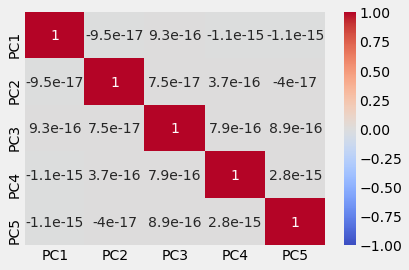

In [22]:
sns.heatmap(X_packages_pca.corr(),
            annot=True,
            fmt='0.2g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap= 'coolwarm');

## PCA in `sklearn`

In [23]:
pca = PCA(n_components=2) # Check out how `n_components` works

X_packages_pca2 = pca.fit_transform(X_packages_scaled)

In [24]:
#what is this? 
pca.explained_variance_

array([3.39821068, 1.00381562])

In [25]:
pca.explained_variance_ratio_

array([0.67964214, 0.20076312])

Sometimes the signs get flipped on the eigenvectors - don't worry about it. Think of "up" and "down" as both representing the same dimension, just in opposite directions.

In [26]:
pca.components_

array([[-0.49219397, -0.50780159, -0.5075545 , -0.49220305,  0.00268878],
       [-0.04575099, -0.03152634,  0.03825687,  0.03337828, -0.9971636 ]])

## Modeling
Then you can use your transformed data as you would in any model
Now let's compare linear regression without PCA to linear regression with PCA. 

Note that we are skipping the validation process with these models - we'll do that later.

In [27]:
#lr no PCA 
lr = LinearRegression()
lr.fit(X_packages_scaled, y_packages_scaled)
lr.score(X_packages_scaled, y_packages_scaled)

0.8551465133243148

In [28]:
#lr with PCA 
lr_pca = LinearRegression()
lr_pca.fit(X_packages_pca2, y_packages_scaled)
lr_pca.score(X_packages_pca2, y_packages_scaled)

0.8520244462637743

# Scenario: Car Properties
Use PCA to reduce the dimensionality of features in the example below: Predict car mpg using car properties. We've done the data prep. Now you practice the modeling, including scoring on the test set.

## Data Prep

In [30]:
cars = pd.read_csv('data/cars.csv')

In [31]:
cars.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.


In [32]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           261 non-null    float64
 1    cylinders    261 non-null    int64  
 2    cubicinches  261 non-null    object 
 3    hp           261 non-null    int64  
 4    weightlbs    261 non-null    object 
 5    time-to-60   261 non-null    int64  
 6    year         261 non-null    int64  
 7    brand        261 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 16.4+ KB


In [33]:
cars[' cubicinches'].replace(' ', np.nan, inplace=True)
cars[' cubicinches'] = cars[' cubicinches'].astype(float)

In [34]:
cars[' weightlbs'].replace(' ', np.nan, inplace=True)
cars[' weightlbs'] = cars[' weightlbs'].astype(float)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(cars.drop('mpg', axis=1),
                                                    cars['mpg'],
                                                   random_state=20)

In [36]:
ct1 = ColumnTransformer(transformers=[
    ('imputer', SimpleImputer(), [1, 3])],
    remainder='passthrough')

In [37]:
ct2 = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [0, 1, 2, 3, 4, 5]),
    ('ohe', OneHotEncoder(), [6])],
    remainder='passthrough')

In [38]:
pipe = Pipeline(steps=[
    ('ct1', ct1),
    ('ct2', ct2)
])

In [39]:
pipe.fit(X_train)

Pipeline(steps=[('ct1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer', SimpleImputer(),
                                                  [1, 3])])),
                ('ct2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5]),
                                                 ('ohe', OneHotEncoder(),
                                                  [6])]))])

In [40]:
X_tr_pp = pipe.transform(X_train)
X_te_pp = pipe.transform(X_test)

## Your Model

In [42]:
#fit linear regression model and score on training and testing data 
## Let's start with a linear regression
lr = LinearRegression().fit(X_tr_pp, y_train)
## Score on train
print(lr.score(X_tr_pp, y_train))
## Score on test
print(lr.score(X_te_pp, y_test))

0.8194994945551486
0.7735358857922057


<details>
    <summary>
        No peeking until you've tried it out first!
    </summary>
<code>
## Let's start with a linear regression
lr = LinearRegression().fit(X_tr_pp, y_train)
## Score on train
lr.score(X_tr_pp, y_train)
## Score on test
lr.score(X_te_pp, y_test)
    </code>
</details>

In [43]:
# Get the coefficients of the best-fit hyperplane

lr.coef_

array([ 2.17732336, -4.6448535 , -1.55471557, -1.15449626, -0.26656104,
        2.60363016,  0.70774264,  0.91202361, -1.61976625])

Thus, our best-fit hyperplane is given by:

$2.177\times in^3\_sd - 4.645\times lbs.\_sd - 1.555\times cyl\_sd - 1.154\times hp\_sd -  0.267\times time_{60}\_sd + 2.604\times yr\_sd + 0.708\times brand_{Europe} + 0.912\times brand_{Japan} - 1.620\times brand_{US}$

In [44]:
cars.columns

Index(['mpg', ' cylinders', ' cubicinches', ' hp', ' weightlbs', ' time-to-60',
       ' year', ' brand'],
      dtype='object')

In [45]:
cars_pca = PCA(n_components=3) 

X_train_new = cars_pca.fit_transform(X_tr_pp)
X_test_new = cars_pca.transform(X_te_pp)

In [46]:
cars_pca.components_

array([[ 0.46506451,  0.43518467,  0.44943159,  0.45378187, -0.34911855,
        -0.18689228, -0.06760958, -0.07285705,  0.14046662],
       [-0.09930756, -0.19558568, -0.1307369 ,  0.00607634, -0.12532964,
        -0.93748658,  0.12914047,  0.02246622, -0.15160669],
       [ 0.14145019,  0.34167073,  0.18676559, -0.14371985,  0.8507263 ,
        -0.23865846,  0.04252368, -0.13151308,  0.08898941]])

The results of our PCA are as follows:

1. **PC1** = 0.465 * cubicinches_sd + 0.435 * weightlbs_sd + 0.449 * cylinders_sd + 0.454 * hp_sd - 0.349 * time-to-60_sd - 0.187 * year_sd - 0.068 * Europe - 0.073 * Japan + 0.140 * US

2. **PC2** = -0.099 * cubicinches_sd - 0.196 * weightlbs_sd - 0.131 * cylinders_sd + 0.006 * hp_sd - 0.125 * time-to-60_sd - 0.937 * year_sd + 0.129 * Europe + 0.022 * Japan - 0.152 * US

3. **PC3** = 0.141 * cubicinches_sd + 0.342 * weightlbs_sd + 0.187 * cylinders_sd - 0.144 * hp_sd + 0.851 * time-to-60_sd - 0.239 * year_sd + 0.043 * Europe - 0.132 * Japan + 0.089 * US

### Modeling with New Dimensions
Now that we have optimized our features, we can build a new model with them!

In [47]:
lr_pca = LinearRegression()
lr_pca.fit(X_train_new, y_train)
lr_pca.score(X_train_new, y_train)

0.7943370879818065

In [48]:
X_test_new = cars_pca.transform(X_te_pp)

In [49]:
lr_pca.score(X_test_new, y_test)

0.716300851467498

In [50]:
lr_pca.coef_

array([-2.96675854, -1.16151928, -2.48560914])

Thus, our best-fit hyperplane is given by:

$-2.967\times PC1 - 1.162\times PC2 -2.486\times PC3$

## Reassembling the whole dataset for the sake of visualization


In [51]:
X_transformed = np.vstack([X_train_new, X_test_new])
y_new = np.concatenate([y_train, y_test])

In [52]:
df = pd.DataFrame(np.hstack([X_transformed, y_new[:, np.newaxis]]),
                  columns=['PC1', 'PC2', 'PC3', 'y'])
df.head()

,PC1,PC2,PC3,y
0,-1.964657,-0.799510,-0.120081,31.3
1,-2.697423,1.117819,1.210028,26.0
2,-1.521356,1.870060,-0.475974,30.0
3,4.196965,1.192402,-1.005452,14.0
4,2.851495,0.150932,0.227496,15.0


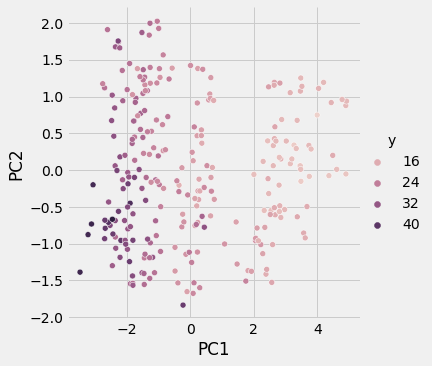

In [53]:
plt.style.use('fivethirtyeight')
sns.relplot(data=df,
            x='PC1',
            y='PC2',
           hue='y');

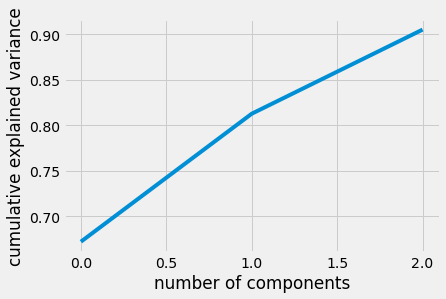

In [54]:
plt.plot(np.cumsum(cars_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

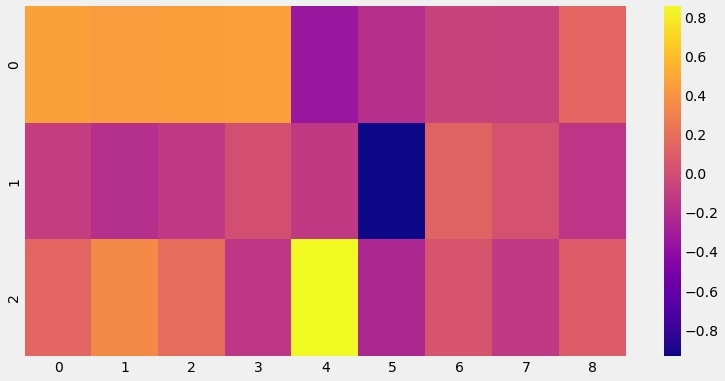

In [55]:
plt.figure(figsize=(12, 6))
sns.heatmap(cars_pca.components_, cmap='plasma');

# Review 
1. How does PCA accomplish dimensionality reduction? 
2. When do you want to use PCA? 
3. Which variables have the greatest influence on PCA? 
4. Can you define what a loading; an eigenvalue and an eigenvector are? 